### 1. Reading in James' simulation data using Pandas

In [1]:
import pandas as pd

file_path = 'dtag/grid/4_agents/4/velocity_metrics.csv'
file_path2 = 'dtag/grid/4_agents/4/idleness.csv'
file_path3 = 'dtag/grid/4_agents/4/vulnerabilities.csv'
file_path4 = 'dtag/grid/4_agents/4/distance_metrics.csv'

df_vel = pd.read_csv(file_path, sep=';', header=None)
df_idle = pd.read_csv(file_path2, sep=';',header=None)
df_vuln = pd.read_csv(file_path3, sep=';',header=None)
df_dist = pd.read_csv(file_path4, sep=';',header=None)

### 2. Cleaning and reshaping data

In [2]:
import numpy as np

N = len(df_vel.T)-1 # number of nodes in the enviroment

# remove timestep column
vel_data = df_vel.iloc[:, 1:N+1]
idle_data = df_idle.iloc[:, 1:N+1].copy() # use copy to avoid modifcation warning
idle_data[idle_data < 0] = np.nan # set negative idle values to NaN for later removal
vuln_data = df_vuln.iloc[:, 1:N+1]
dist_data = df_dist.iloc[:, 1:N+1]

# combine datasets 
df = pd.concat([vel_data,idle_data,dist_data,vuln_data],axis=1)
df = df.replace([np.inf, -np.inf], np.nan) # set all inf values to NaN for later removal

# Drop rows with NaN values
df = df.dropna()

# attack length threshold to determine attack success and update to binary classification:
threshold = 50
for col in range(N*3,N*4):
    df.iloc[:, col] = (df.iloc[:, col] >= threshold).astype(int)

# convert data to array
dataset = df.to_numpy()

# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
trainX, trainY, testX, testY = dataset[0:train_size,0:-N], dataset[0:train_size,N*3:N*4],dataset[train_size:len(dataset),0:-N], dataset[train_size:len(dataset),N*3:N*4] 
#split is appropriate as it trains on the first set of timestep values

# reshape data to appropriate format as (timestep, number of nodes, number of features)
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[-1]//3,3))
testX = np.reshape(testX, (testX.shape[0],testX.shape[-1]//3,3))

### 3. Create adjacency matrix for data's respective enviroment

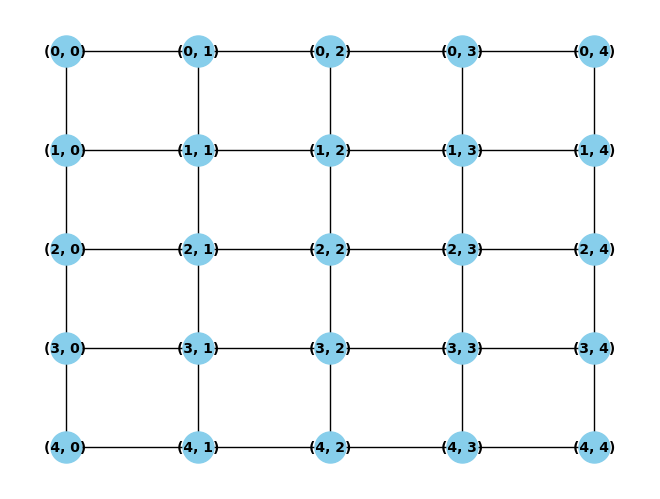

In [3]:
import networkx as nx

# Create node mappings
G = nx.grid_2d_graph(5, 5)

# convert to array
adjacency_matrix = nx.adjacency_matrix(G)
adjacency_matrix = adjacency_matrix.toarray()

# reshape to work with GNN and timeseries data
adjacency_matrix_train = np.repeat(adjacency_matrix[np.newaxis, :, :], train_size, axis=0)
adjacency_matrix_test = np.repeat(adjacency_matrix[np.newaxis, :, :], test_size, axis=0)

#------------------------------------------------------------------------------------------------------------------------------------------------
# Visualise the enviroment for verification
#------------------------------------------------------------------------------------------------------------------------------------------------

import matplotlib.pyplot as plt

# Plot the graph
pos = {(x, y): (y, -x) for x, y in G.nodes()}
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')

plt.axis('off')
plt.show()

### 4. Compile and fit model

In [4]:
from Intruder_functionality import machine_learning as ml

data_shape = (trainX.shape[1], trainX.shape[-1])
adjacency_shape = adjacency_matrix_train.shape[1:]

# Create an instance of the GraphConvolutionalNetwork
gcn_model = ml.ML_Intruder(data_shape, adjacency_shape)

# Compile the model
gcn_model.compile()

# Fit the model to the data
gcn_model.fit(trainX, adjacency_matrix_train, trainY, epochs=10, batch_size=1, verbose=2)

2024-01-10 21:08:32.293722: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
14869/14869 - 15s - loss: 0.5272 - accuracy: 0.1067 - 15s/epoch - 982us/step
Epoch 2/10
14869/14869 - 15s - loss: 0.3173 - accuracy: 0.1296 - 15s/epoch - 1ms/step
Epoch 3/10
14869/14869 - 15s - loss: 0.3045 - accuracy: 0.1568 - 15s/epoch - 982us/step
Epoch 4/10
14869/14869 - 14s - loss: 0.2992 - accuracy: 0.1526 - 14s/epoch - 934us/step
Epoch 5/10
14869/14869 - 15s - loss: 0.2967 - accuracy: 0.1511 - 15s/epoch - 1ms/step
Epoch 6/10
14869/14869 - 15s - loss: 0.2944 - accuracy: 0.1483 - 15s/epoch - 981us/step
Epoch 7/10
14869/14869 - 13s - loss: 0.2928 - accuracy: 0.1537 - 13s/epoch - 875us/step
Epoch 8/10
14869/14869 - 13s - loss: 0.2922 - accuracy: 0.1511 - 13s/epoch - 906us/step
Epoch 9/10
14869/14869 - 14s - loss: 0.2908 - accuracy: 0.1529 - 14s/epoch - 927us/step
Epoch 10/10
14869/14869 - 14s - loss: 0.2902 - accuracy: 0.1477 - 14s/epoch - 930us/step


In [5]:
# Print the model summary
gcn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 node_input (InputLayer)     [(None, 25, 3)]              0         []                            
                                                                                                  
 adjacency_input (InputLaye  [(None, 25, 25)]             0         []                            
 r)                                                                                               
                                                                                                  
 gcn_layer (GCNLayer)        (None, 25, 3)                2         ['node_input[0][0]',          
                                                                     'adjacency_input[0][0]']     
                                                                                              

### 5. Overall Performance Review 

In [6]:
threshold = 0.5
train_predict = gcn_model.predict(trainX, adjacency_matrix_train)
train_predict_binary = gcn_model.binary_predict(threshold)
test_predict = gcn_model.predict( testX, adjacency_matrix_test)
test_predict_binary = gcn_model.binary_predict(threshold)


465/465 [==============================] - 1s 1ms/step
Accuracy: 0.8757199542672675
F1 Score: 0.7341214116347061
200/200 [==============================] - 0s 1ms/step
Accuracy: 0.866549505727287
F1 Score: 0.7142818748656202
